**автоматический переводчик на основе рекуррентных нейросетей seq2seq**

Евгений Борисов borisov.e@solarl.ru

In [1]:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

## Библиотеки

In [2]:
import numpy as np
import gzip

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )    

## Данные

http://www.manythings.org/anki/   

In [4]:
# список фраз на английском с переводом на русский
with gzip.open('../data/text/rus-eng/rus.txt.gz', 'rt', encoding='utf-8') as f:
    lines = f.read().lower().split('\n')

ppr(lines)    

записей: 336 667


---

In [5]:
# фразы упорядоченны по длине, выберем среднюю длину
lines = [ lines[i] for i in range(100000,110000) ]
ppr(lines)  

записей: 10 000


In [6]:
# разбираем строки на русские и английские с сохранением порядка

# определим специальные символы - начало и конец фразы
GO='\t' # символ <старт>
EOS='\n' # символ <стоп>

input_texts  = [ s.split('\t')[0] for s in lines if s ] 
target_texts = [ GO + ' ' + s.split('\t')[1]+ ' ' + EOS for s in lines if s ]

In [7]:
# входной и выходной алфавиты
input_characters  = sorted(set(' '.join(input_texts)))
target_characters = sorted(set(' '.join(target_texts)))

In [8]:
# размер входного алфавита
num_encoder_tokens = len(input_characters) 
# максимальная длина входной фразы в символах 
max_encoder_seq_length = max([len(txt) for txt in input_texts])

# размер выходного алфавита
num_decoder_tokens = len(target_characters)
# максимальная длина выходной фразы в символах 
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [9]:
# нумеруем символы в алфавите
input_token_index = { char:i for i, char in enumerate(input_characters) }
target_token_index = { char:i  for i, char in enumerate(target_characters) }

## кодируем текст

In [10]:
# строим статистическую модель порождения текста 

# Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares,
#     Holger Schwenk, Yoshua Bengio
# Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation
# 3 Sep 2014
# https://arxiv.org/abs/1406.1078


# statistical machine translation system (SMT)

# the goal of the system (decoder,specifically) is to 
# find a translation f given a source sentence e, which maximizes

# p(f|e) ∝ p(e|f)p(f)

In [11]:
# для каждого примера
#   строим таблицу индикаторов  {0,1}
#     [ номер символа в строке, номер символа в алфавите ] 

In [12]:
# данные энкодера 

# входная последовательность генерирует выход по схеме many2one 
#   выход энкодера выкидываем
#    используем только его конечное состояние
#      первым входом декодера есть служебное слово <пуск>
encoder_input_data = np.zeros( (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

for s, input_text in enumerate(input_texts):
    for w, c in enumerate(input_text):
        encoder_input_data[s, w, input_token_index[c]] = 1.

In [13]:
# данные декодера (для целевой последовательности), 

# память декодера инициализируеться конечным состянием памяти энкодера 
#   и на вход подаём служебное слово <пуск>    
#    далее рекурсивно - очередной выход декодера подаёться на вход и генерирует следующий выход

# вход декодера
decoder_input_data = np.zeros( (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
# выход декодера (вход смещённый на один шаг)
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, target_text in enumerate(target_texts):
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

## модель

In [14]:
latent_dim = 512  # размер сети

In [15]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [16]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [17]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 47)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 67)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 512), (None, 1146880     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 512),  1187840     input_2[0][0]                    
                                                                 lstm[0][1]                   

In [19]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [20]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model, 
#                  show_shapes=True,
#                  show_layer_names=True).create(prog='dot',format='svg'))

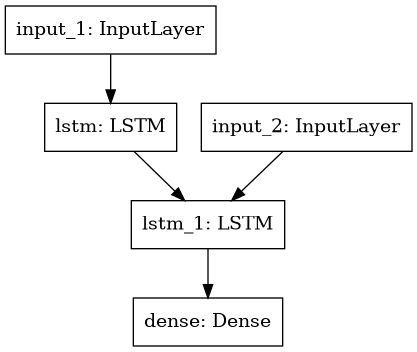

In [21]:
import IPython
from tensorflow.keras.utils import plot_model

# plot_model(model,to_file='result/model.png', show_layer_names=False, show_shapes=True )
plot_model(model,to_file='model.png', show_layer_names=True, show_shapes=False )

IPython.display.Image('model.png')

In [22]:
# import IPython
# from tensorflow.keras.utils import plot_model
# plot_model(model,to_file='model.png' ,show_shapes=True, show_layer_names=True)

# IPython.display.Image('model.png')


## обучаем модель

In [23]:
%%time 

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=100,epochs=150,)

Train on 10000 samples
Epoch 1/150
10000/10000 [==============================] - 7s 652us/sample - loss: 1.1616
Epoch 2/150
10000/10000 [==============================] - 4s 386us/sample - loss: 0.9371
Epoch 3/150
10000/10000 [==============================] - 4s 404us/sample - loss: 0.8265
Epoch 4/150
10000/10000 [==============================] - 4s 417us/sample - loss: 0.7701
Epoch 5/150
10000/10000 [==============================] - 4s 413us/sample - loss: 0.7156
Epoch 6/150
10000/10000 [==============================] - 4s 412us/sample - loss: 0.6781
Epoch 7/150
10000/10000 [==============================] - 4s 409us/sample - loss: 0.6296
Epoch 8/150
10000/10000 [==============================] - 4s 397us/sample - loss: 0.5936
Epoch 9/150
10000/10000 [==============================] - 4s 394us/sample - loss: 0.5667
Epoch 10/150
10000/10000 [==============================] - 4s 385us/sample - loss: 0.5341
Epoch 11/150
10000/10000 [==============================] - 4s 383us/sample 

10000/10000 [==============================] - 4s 390us/sample - loss: 0.0567
Epoch 83/150
10000/10000 [==============================] - 4s 389us/sample - loss: 0.0553
Epoch 84/150
10000/10000 [==============================] - 4s 386us/sample - loss: 0.0548
Epoch 85/150
10000/10000 [==============================] - 4s 387us/sample - loss: 0.0535
Epoch 86/150
10000/10000 [==============================] - 4s 387us/sample - loss: 0.0528
Epoch 87/150
10000/10000 [==============================] - 4s 387us/sample - loss: 0.0518
Epoch 88/150
10000/10000 [==============================] - 4s 387us/sample - loss: 0.0509
Epoch 89/150
10000/10000 [==============================] - 4s 386us/sample - loss: 0.0501
Epoch 90/150
10000/10000 [==============================] - 4s 385us/sample - loss: 0.0493
Epoch 91/150
10000/10000 [==============================] - 4s 386us/sample - loss: 0.0488
Epoch 92/150
10000/10000 [==============================] - 4s 385us/sample - loss: 0.0479
Epoch 93/150

In [24]:
# Save model
# model.save('s2s.h5')

## Тестируем

In [25]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [26]:
reverse_input_char_index = { i:char for char,i in input_token_index.items() }
reverse_target_char_index = { i:char for char,i in target_token_index.items() }

In [27]:
def decode_sequence(input_seq):
    # генерируем состояние энкодера
    states_value = encoder_model.predict(input_seq)

    # вход декодера - последовательность из одного слова GO
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index[GO]] = 1.

    # выходную последовательность
    stop_condition = False
    decoded_sentence = ''
    
    for i in range(max_decoder_seq_length): 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # декодируем символ
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # если очередной символ это EOS
        if(sampled_char==EOS): break # то завершаем работу

        # обновляем входную последовательность
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # обновляем состояние сети
        states_value = [h, c]

    return decoded_sentence

In [28]:
ii = np.random.permutation(len(encoder_input_data))[:100]
for seq_index in ii:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print( input_texts[seq_index],' -> ', decoded_sentence)

fashions change quickly.  ->   мода быстро меняется. 

are those your students?  ->   это ваши студенты? 

you must get up at six.  ->   ты должен встать в шесть. 

are you a freshman, too?  ->   ты тоже новичок? 

i'm the youngest child.  ->   я самый младший ребёнок. 

the door was left ajar.  ->   дверь останили полуоткрытой. 

are you blackmailing me?  ->   ты меня шантажируешь? 

it's a pretty big club.  ->   это довольно большой клуб. 

tom used to be wealthy.  ->   том был когда-то богат. 

tom was 13 at the time.  ->   тому в то время было тринадцать. 

tom just saved my life.  ->   том только что спас мне жизнь. 

the batteries are dead.  ->   батарейки сдохли. 

does tom have a bicycle?  ->   у тома есть велосипед? 

tom also speaks french.  ->   том тоже говорит на французском. 

let's do this together.  ->   давай сделаем это вместе. 

tom changed everything.  ->   том всё изменил. 

we met her by accident.  ->   мы случайно её встретили. 

tom was just not ready.  ->   том

---

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

In [33]:
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

if tf.test.is_built_with_cuda():
    print('GPU devices:\n  ',
        [ [x.name, x.physical_device_desc] 
          for x in device_lib.list_local_devices() 
          if x.device_type == 'GPU' ]
    )
    print('default GPU device:', tf.test.gpu_device_name() )

else:
    print('no GPU device found')
    

tensorflow: 2.0.0
keras: 2.2.4-tf
GPU devices:
   [['/device:GPU:0', 'device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1']]
default GPU device: /device:GPU:0
